# Integrating LSTM-Based Solar Energy Forecasting for IoT Sensor Nodes

# Introduction
This notebook details the integration of an LSTM model for predicting future solar energy into sensor nodes equipped with the STM32L4S5VIT6 microcontroller, part of the B-L4S5I-IOT01A development board. 

The ultimate goal is to deploy these boards in remote locations to measure environmental parameters using sensors and transmit the data to a server via LoRa. Since data transmission consumes significant energy, and the device relies solely on solar power, the integration of a machine learning model will enable real-time, on-device solar energy forecasting. This allows the board to adapt its transmission and measurement frequency, preventing energy depletion and enhancing the operational efficiency and sustainability of the solar-powered sensor board.

# Data Collection and Preparation

## Load the Dataset

In [42]:
import os
import requests
import pandas as pd

filename='solar_energy_dataset.csv'

if not os.path.exists(filename):
    # Download the dataset from google drive
            1CgREtdvmZvbc7hIvA11TIbqeJL-_sREd
    fileid='1CgREtdvmZvbc7hIvA11TIbqeJL-_sREd'
    file_url = 'https://drive.google.com/uc?export=download&id=' + fileid
    response = requests.get(file_url)

    with open(filename, 'wb') as file:
        file.write(response.content)

dataset = pd.read_csv(filename)

Solar energy forecasting is achieved by predicting Global Horizontal Irradiance (GHI) values with an LSTM model using various input features. GHI measures the total solar radiation on a horizontal surface, including direct and diffuse radiation, and is expressed in watts per square meter (W/m²). It is essential for solar energy applications as it indicates the solar energy available for conversion into electricity by solar panels. Accurate GHI forecasting helps predict solar power availability, allowing the board to adjust its energy usage and transmission based on anticipated solar input, thus optimizing its performance and sustainability.

Here is what the GHI data looks like over time:

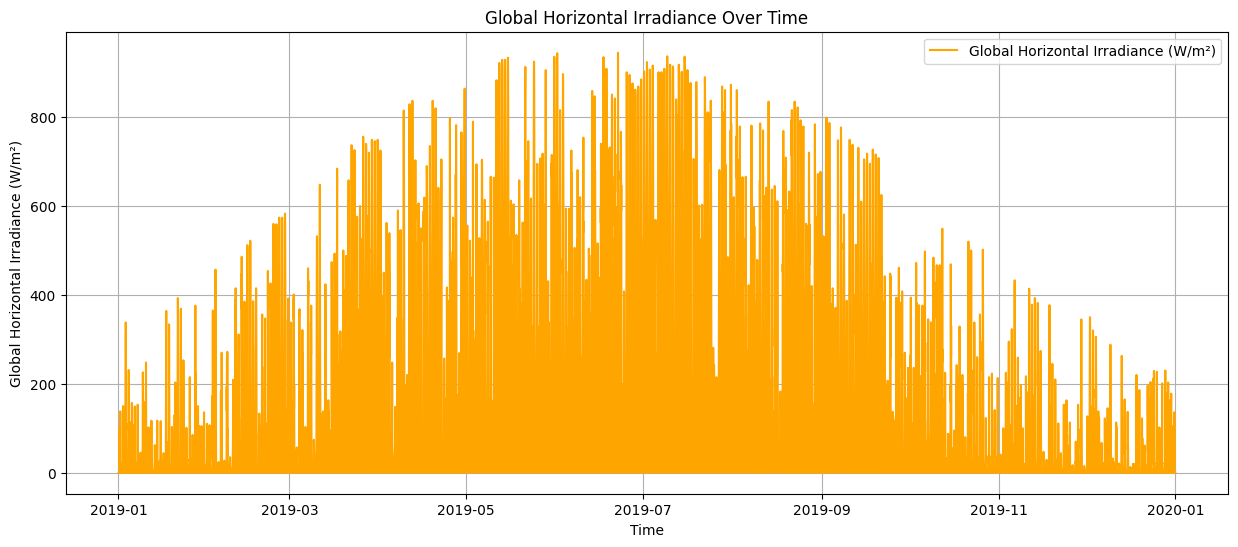

In [43]:
import matplotlib.pyplot as plt

# Creating a TIMESTAMP column by combining Year, Month, Day, and Hour
dataset['TIMESTAMP'] = pd.to_datetime(dataset[['Year', 'Month', 'Day', 'Hour']])

# Plotting GHI over time
plt.figure(figsize=(15, 6))
plt.plot(dataset['TIMESTAMP'], dataset['GHI'], label='Global Horizontal Irradiance (W/m²)', color='orange')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Global Horizontal Irradiance Over Time')
plt.legend()
plt.grid(True)
plt.show()

We can also focus on the GHI data for a week to see the daily patterns:

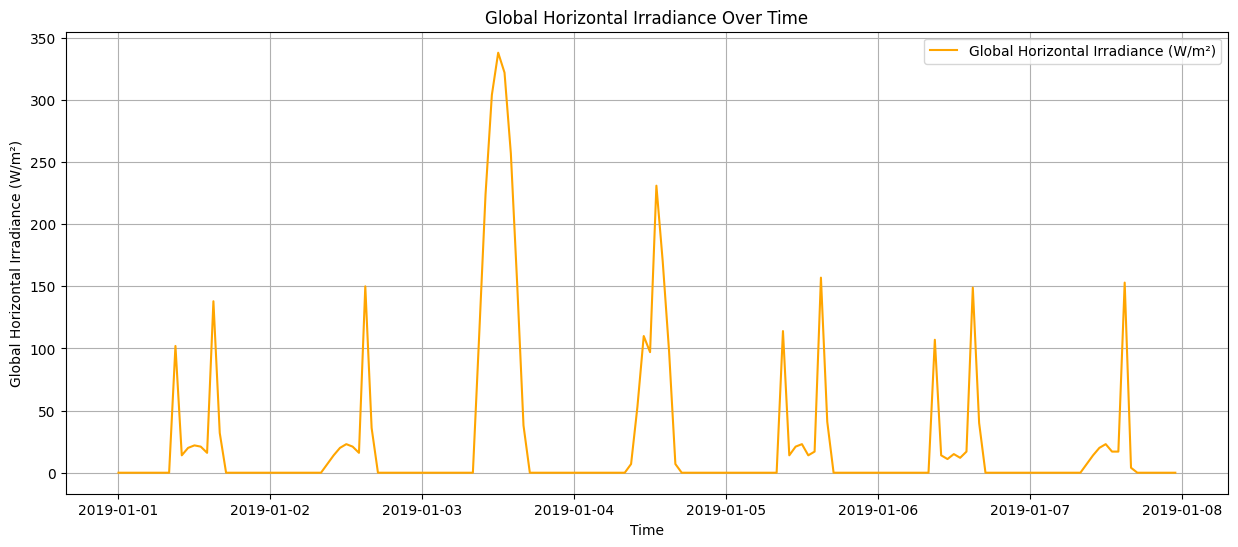

In [44]:
# Plot a few days of GHI
plt.figure(figsize=(15, 6))
plt.plot(dataset['TIMESTAMP'][0:168], dataset['GHI'][0:168], label='Global Horizontal Irradiance (W/m²)', color='orange')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Global Horizontal Irradiance Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Data Preparation and Feature Engineering

The data exhibits a daily seasonality pattern, with higher GHI values during the day and lower values at night. By decomposing the data, we can visualize the trend, seasonality, and residuals. This decomposition allows us to incorporate the trend and seasonality components as features in the LSTM model, enhancing its ability to capture daily patterns and improve prediction accuracy.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

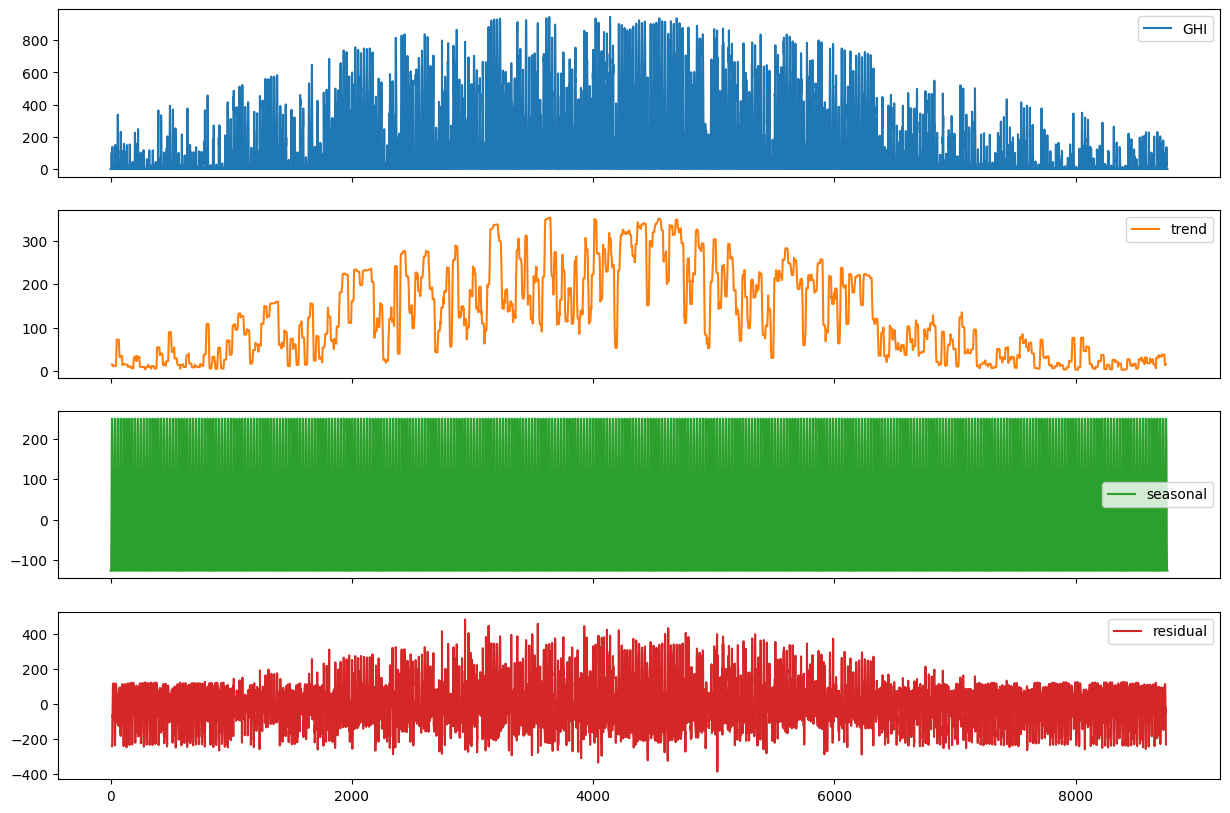

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(dataset['GHI'], period=24)
dataset['trend'] = decomposition.trend
dataset['seasonal'] = decomposition.seasonal
dataset['residual'] = decomposition.resid

# Plotting the trend, seasonal, and residual components
dataset[['GHI', 'trend', 'seasonal', 'residual']].plot(subplots=True, figsize=(15, 10))

Our dataset now includes three features: GHI, trend, and seasonality (we choose to ignore residual because it's too close to noise). To ensure that the model focuses on overall trends rather than short-term fluctuations, we compute rolling means of these features over 3, 6, and 12-hour windows. These rolling mean features smooth out short-term variations, highlight longer-term patterns, and provide the LSTM model with a more stable understanding of solar irradiance. This approach improves the model's ability to capture significant trends, enhancing the accuracy and reliability of its solar energy forecasts.

In [45]:
dataset['GHI_rolling_3'] = dataset['GHI'].rolling(window=3).mean()
dataset['GHI_rolling_6'] = dataset['GHI'].rolling(window=6).mean()
dataset['GHI_rolling_12'] = dataset['GHI'].rolling(window=12).mean()

Let's visualize the rolling mean features for a week:

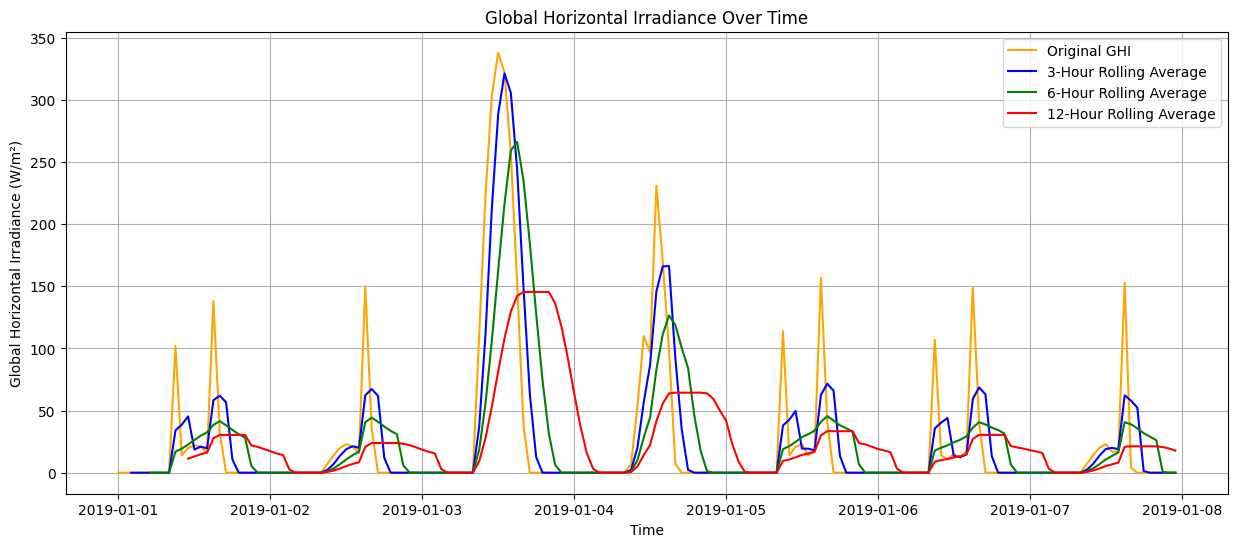

In [46]:
# Plotting the original GHI data and the rolling averages
plt.figure(figsize=(15, 6))
plt.plot(dataset['TIMESTAMP'][0:168], dataset['GHI'][0:168], label='Original GHI', color='orange')
plt.plot(dataset['TIMESTAMP'][0:168], dataset['GHI_rolling_3'][0:168], label='3-Hour Rolling Average', color='blue')
plt.plot(dataset['TIMESTAMP'][0:168], dataset['GHI_rolling_6'][0:168], label='6-Hour Rolling Average', color='green')
plt.plot(dataset['TIMESTAMP'][0:168], dataset['GHI_rolling_12'][0:168], label='12-Hour Rolling Average', color='red')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Global Horizontal Irradiance Over Time')
plt.legend()
plt.grid(True)
plt.show()

We can observe that the rolling mean features indeed smooth out short-term fluctuations and highlight longer-term trends. It makes sense to include these features because at the end of the day, we need to predict the solar energy available for the next few hours, not the minute-to-minute variations.

Now our dataset contains 6 features:

In [48]:
# Keeping only the relevant columns
dataset = dataset[['GHI', 'GHI_rolling_3', 'GHI_rolling_6', 'GHI_rolling_12', 'trend', 'seasonal']]
dataset.bfill(inplace=True)

## Data Splitting and Normalization

Now that we have prepared our dataset with the necessary features, we split it into training and testing sets. We use the first 80% of the data for training and the remaining 20% for testing. 

In [54]:
train_data = dataset[:int(0.8*len(dataset))].to_numpy()
test_data = dataset[int(0.8*len(dataset)):].to_numpy()

We now need to normalize the data to ensure that all features are on a similar scale. 

In [55]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
ghi_scaler = MinMaxScaler()

ghi_train = train_data[:, 0].reshape(-1, 1)
ghi_test = test_data[:, 0].reshape(-1, 1)

fitted_scaler = scaler.fit(train_data[:, 1:])  # Fit on all features except GHI
fitted_ghi_scaler = ghi_scaler.fit(ghi_train)

scaled_train_data = scaler.transform(train_data[:, 1:])
scaled_train_ghi = ghi_scaler.transform(ghi_train)

scaled_test_data = scaler.transform(test_data[:, 1:])
scaled_test_ghi = ghi_scaler.transform(ghi_test)

# Combine scaled GHI and other features
scaled_train = np.hstack((scaled_train_ghi, scaled_train_data))
scaled_test = np.hstack((scaled_test_ghi, scaled_test_data))


## Data Sequencing

In order to train an LSTM model, we need to convert our dataset into sequences of input-output pairs. Each input sequence contains a window of past observations, while the corresponding output is the GHI value at the next time step. In our case, we use a sequence length of 24 hours, which corresponds to the number of observations in a day.

In [56]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])   
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 24
x_train, y_train = create_sequences(scaled_train, time_steps)
x_test, y_test = create_sequences(scaled_test, time_steps)

Let's now create and train our model.

# Model Training

The model architecture consists of two LSTM layers separated by dropout layers to prevent overfitting. The output layer is a dense layer with a relu activation function to ensure non-negative predictions. The model is trained using the Adam optimizer with a mean squared error loss function. We also use two callbacks: EarlyStopping to prevent overfitting and ReduceLROnPlateau to adjust the learning rate during training.

Note: Since the deployment tool used later only supports Keras 2.x, we need to use TensorFlow 2.15 or earlier.

In [49]:
import tensorflow as tf

if tf.__version__ != '2.15.0':
    %pip install tensorflow==2.15
    
print("TensorFlow version: ", tf.__version__)

2024-08-30 17:55:01.543529: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 17:55:01.570975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 17:55:01.571013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 17:55:01.571990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 17:55:01.577462: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 17:55:01.578294: I tensorflow/core/platform/cpu_feature_guard.cc:1

TensorFlow version:  2.15.0


In [50]:
# Set random seed for reproducibility
np.random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

Let's build our model.

In [57]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model(x_train, y_train, epochs=100, batch_size=64, units=50, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, callbacks=[early_stopping, reduce_lr])
    
    return model, history

model, history = create_model(x_train, y_train, epochs=100, batch_size=64, units=12, lr=0.001)


Epoch 1/100
77/77 [==============================] - 4s 17ms/step - loss: 0.0336 - val_loss: 0.0087 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 1s 10ms/step - loss: 0.0116 - val_loss: 0.0057 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 1s 10ms/step - loss: 0.0100 - val_loss: 0.0052 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 1s 10ms/step - loss: 0.0092 - val_loss: 0.0053 - lr: 0.0010
Epoch 5/100
77/77 [==============================] - 1s 10ms/step - loss: 0.0085 - val_loss: 0.0052 - lr: 0.0010
Epoch 6/100
77/77 [==============================] - 1s 10ms/step - loss: 0.0083 - val_loss: 0.0050 - lr: 0.0010
Epoch 7/100
77/77 [==============================] - 1s 10ms/step - loss: 0.0081 - val_loss: 0.0051 - lr: 0.0010
Epoch 8/100
77/77 [==============================] - 1s 11ms/step - loss: 0.0078 - val_loss: 0.0051 - lr: 0.0010
Epoch 9/100
77/77 [==============================] - 1s 10ms/step - loss: 0.0076 - val_loss: 0.0

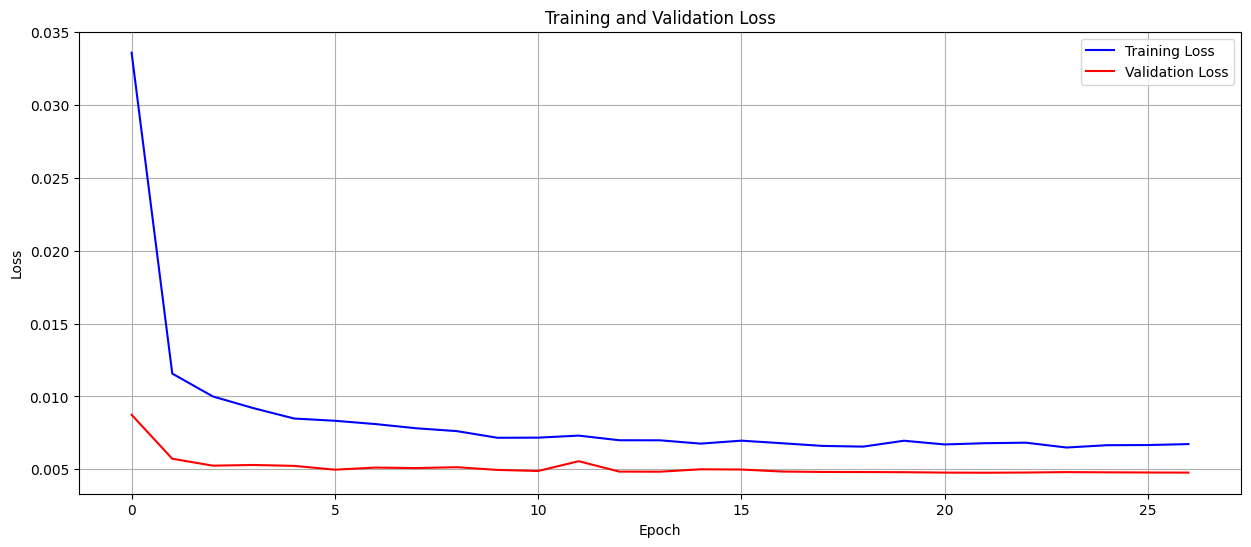

In [59]:
# Plotting the training and validation loss
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Now that our model is trained, we can evaluate its performance on the test set.


54/54 [==============================] - 1s 3ms/step


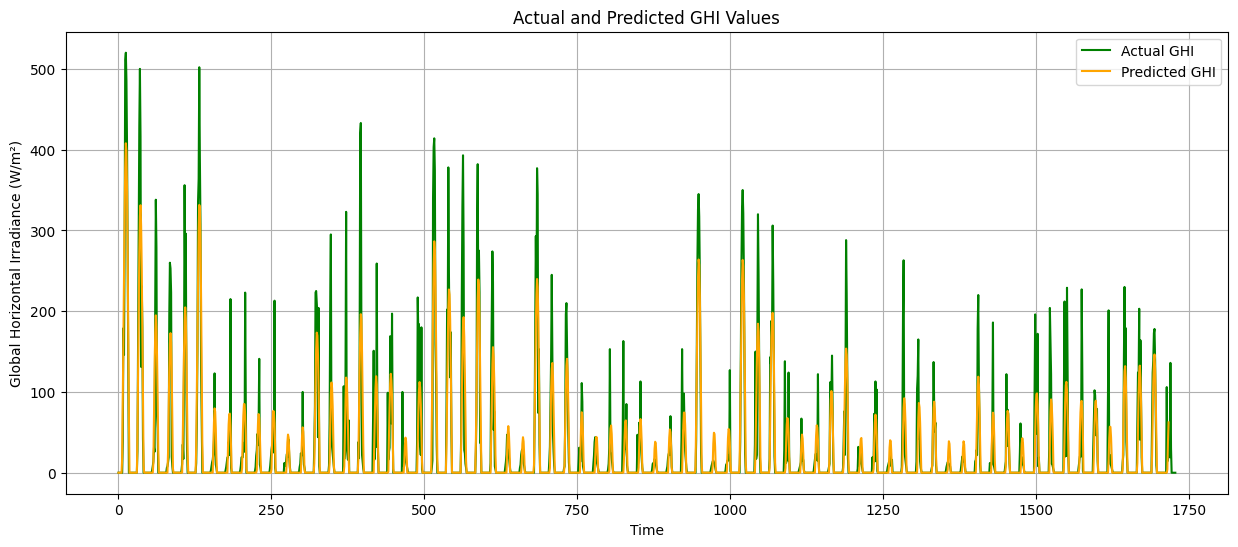

In [60]:
# Make predictions on the test data
predicted_test = model.predict(x_test)

# Inverse transform the predictions and actual values
predicted_test = ghi_scaler.inverse_transform(predicted_test.reshape(-1, 1))
y_test_ghi = ghi_scaler.inverse_transform(y_test.reshape(-1, 1))

# Ensure the predictions are non-negative
predicted_test = np.maximum(predicted_test, 0)

# Plotting the actual and predicted GHI values
plt.figure(figsize=(15, 6))
plt.plot(y_test_ghi, label='Actual GHI', color='green')
plt.plot(predicted_test, label='Predicted GHI', color='orange')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual and Predicted GHI Values')
plt.legend()
plt.grid(True)
plt.show()



The results look good, with the actual and predicted showing similar patterns. We can calculate some metrics to quantify the model's performance.

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# remove the NaN values from the data
mask = ~np.isnan(y_test_ghi) & ~np.isnan(predicted_test)
y_test_ghi = y_test_ghi[mask]
predicted_test = predicted_test[mask]

# Calculate the evaluation metrics
mse = mean_squared_error(y_test_ghi, predicted_test)
mae = mean_absolute_error(y_test_ghi, predicted_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_ghi, predicted_test)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('R² Score:', r2)


Mean Squared Error: 1383.525665430997
Mean Absolute Error: 16.047250799856425
Root Mean Squared Error: 37.19577483305056
R² Score: 0.748129271763518


We can see that the model has a MAE of 16.4W/m², which is quite low considering the GHI values range from 0 to 600W/m². The model's performance is satisfactory for our application. 

# Model Deployment

Now that we have a trained model, we can deploy it to B-L4S5I-IOT01A development board. The complete workflow is explained in a previous notebook [here](https://github.com/Kiboya/Machine-Learning-Notebooks/blob/012723f985c0a57d1b344c861f41c558ccdfcbc4/TensorFlow%20Lite%20For%20Microcontrollers/tflm_model_deployment_and_test.ipynb). However, the nature of our model requires some modifications to the deployment process:

- We can't use TensorFlow Lite for Microcontrollers because, as of now, STM32Cube.AI (v9.0.0) doesn't support certain layers used in our model (for more information, see [here](https://community.st.com/t5/edge-ai/error-while-analyzing-a-neural-network-tflite-model-in-stm32/m-p/673276/highlight/true#M2592)). 
- The version of Keras used to train the model needs to be 2.15 or earlier to be compatible with the version of Keras used in STM32Cube.AI (v9.0.0) (for more information, see [here](https://community.st.com/t5/edge-ai/unrecognized-keyword-arguments-batch-shape-with-loading-keras/m-p/650450/highlight/true#M2420)). In our case, we made sure to use Keras 2.15 for training the model. Also, the model needs to be saved in the .h5 format to be compatible with STM32Cube.AI.
- We need to generate C data for the input features (GHI, trend, and seasonality) and the rolling mean features to feed into the model. This data will be used to make predictions on the board.

Let's begin by saving the model in the .h5 format.

In [58]:
model.save('ghi_prediction_model.h5')

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate C Data

To facilitate the input of the features into the model, we are going to generate a header file containing the data in C format as arrays. This header file will be included in the STM32 project to make predictions on the board.

Let's first reshape the test data.

In [61]:
# reshape to (NUMBER_OF_SAMPLES, SEQUENCE_LENGTH, NUMBER_OF_FEATURES, 1)
input_data = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
output_data = np.reshape(y_test, (y_test.shape[0], 1, 1, 1))

# replace possible NaN values with 0
input_data = np.nan_to_num(input_data)
output_data = np.nan_to_num(output_data)

# Check the shape of the input and output data
print('Input data shape:', input_data.shape)
print('Output data shape:', output_data.shape)

Input data shape: (1728, 24, 6, 1)
Output data shape: (1728, 1, 1, 1)


Now that we have the test data in the correct shape, we can generate the C data.

In [62]:
def format_array_for_c(arr):
    """Convert a numpy array into a C-style initializer with nested curly braces."""
    arr_str = np.array2string(arr, separator=',', threshold=arr.size, precision=6, formatter={'float_kind': lambda x: f'{x:.6f}'})
    arr_str = arr_str.replace('[', '{').replace(']', '}')
    return arr_str

x_test_str = format_array_for_c(input_data)
y_test_str = format_array_for_c(output_data)

# Write to a header file
with open('ghi_test_data.h', 'w') as f:
    f.write('#ifndef GHI_TEST_DATA_H\n')
    f.write('#define GHI_TEST_DATA_H\n\n')

    f.write(f'#define SAMPLES 1740\n')
    f.write(f'#define SEQUENCE_LENGTH 12\n')
    f.write(f'#define FEATURES 6\n')

    f.write(f'static const float x_test[SAMPLES][SEQUENCE_LENGTH][FEATURES][1] = {x_test_str};\n\n')
    f.write(f'static const float y_test[SAMPLES][1][1][1] = {y_test_str};\n\n')

    f.write('#endif // GHI_TEST_DATA_H\n')

## Testing the Model on the Board

Now that the header file is generated, we can continue with the deployment process as explained in the previous [notebook](https://github.com/Kiboya/Machine-Learning-Notebooks/blob/012723f985c0a57d1b344c861f41c558ccdfcbc4/TensorFlow%20Lite%20For%20Microcontrollers/tflm_model_deployment_and_test.ipynb).

Once the project has been successfully built and flashed to the board, we can log the predictions and compare them with the actual GHI values.

In [64]:
import pandas as pd
import os

FILE_NAME = 'ghi_prediction.log'
START_MARKER = 'BeginCSVLog'
END_MARKER = 'EndCSVLog'

# Check if the file exists, otherwise raise an error
if not os.path.exists(FILE_NAME):
    raise FileNotFoundError(f"File '{FILE_NAME}' not found.")

collect_lines = False
csv_lines = []

# Read the file line by line to remove the non-csv data
with open(FILE_NAME, 'r') as file:
    for line in file:
        if START_MARKER in line:
            collect_lines = True
            continue
        if END_MARKER in line:
            collect_lines = False
        if collect_lines:
            csv_lines.append(line)

csv_content = ''.join(csv_lines)

# Load the collected lines into a DataFrame
from io import StringIO

df = pd.read_csv(StringIO(csv_content))

We can then rescale the data, add a column for the x axis, and plot the results.

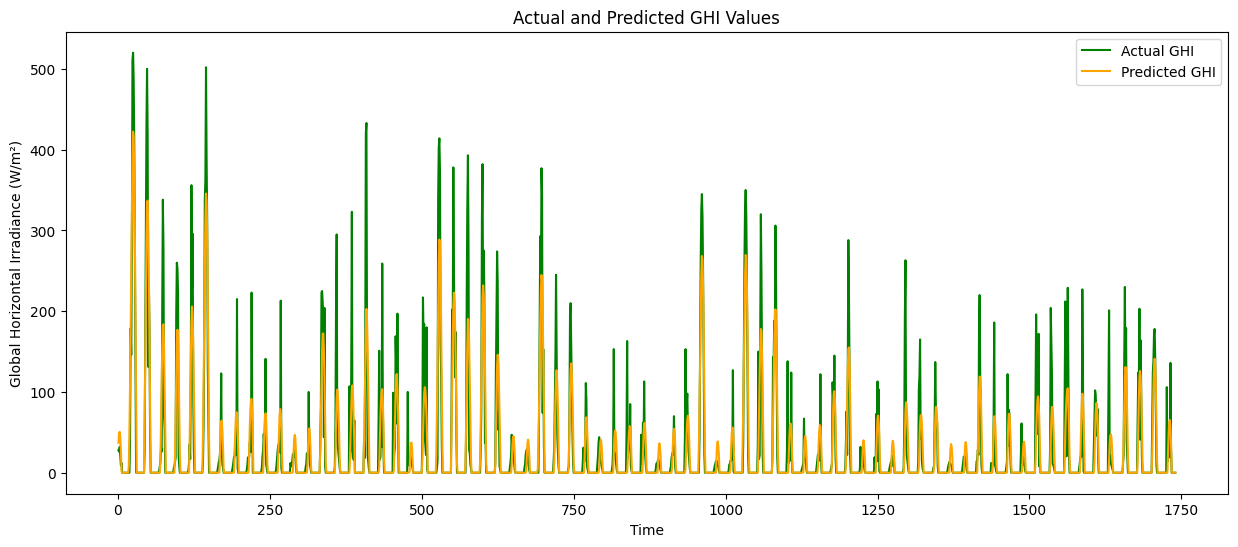

In [68]:
# Rescale the values
df['y_prediction'] = ghi_scaler.inverse_transform(df['y_prediction'].values.reshape(-1, 1))
df['y_actual'] = ghi_scaler.inverse_transform(df['y_actual'].values.reshape(-1, 1))

# Add column for x values
df['x_input'] = range(1, len(df) + 1)

# Plot
plt.figure(figsize=(15, 6))

# Plot the actual values
plt.plot(df['x_input'], df['y_actual'], label='Actual GHI', color='green')

# Plot the predicted values (on target)
plt.plot(df['x_input'], df['y_prediction'], label='Predicted GHI', color='orange')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual and Predicted GHI Values')
plt.legend()

# Show the plot
plt.show()

The results look promising, with the model accurately capturing the daily patterns of GHI values. We have similar results to the ones obtained during testing, indicating that the model is performing well on the board.

## On-Target Validation

The next step is to perform on-target validation to obtain more accurate metrics. This involves using the validation tool provided by STM32Cube.AI to evaluate the model's performance on the board. The process is again detailed in the previous [notebook](https://github.com/Kiboya/Machine-Learning-Notebooks/blob/012723f985c0a57d1b344c861f41c558ccdfcbc4/TensorFlow%20Lite%20For%20Microcontrollers/tflm_model_deployment_and_test.ipynb).

What we need to do is to export the input and output data to numpy files and give them to the validation tool. The tool will then run the model on the board and give us the metrics.

In [69]:
# Save npy input and output
np.save('x_test.npy', input_data)
np.save('y_test.npy', output_data)

After running the validation tool, we can analyze the results.

```

  ST.AI Profiling results v1.2 - "network"
  ---------------------------------------------------------------
  nb sample(s)      :   1740
  duration          :   7.555 ms by sample (7.537/7.603/0.012)
  macc              :   25646
  cycles/MACC       :   35.35
  CPU cycles        :   [906,654]
  used stack/heap   :   not monitored/0 bytes
  ---------------------------------------------------------------
   Inference time per node
   --------------------------------------------------------------------------------------
   c_id    m_id   type              dur (ms)       %    cumul  CPU cycles    name
   --------------------------------------------------------------------------------------
   0       0      LSTM (0x181)         3.608   47.8%    47.8%  [ 433,013 ]   ai_node_0
   1       2      LSTM (0x181)         3.935   52.1%    99.8%  [ 472,216 ]   ai_node_1
   2       4      Dense (0x104)        0.009    0.1%   100.0%  [   1,065 ]   ai_node_2
   3       4      NL (0x107)           0.003    0.0%   100.0%  [     360 ]   ai_node_3
   --------------------------------------------------------------------------------------
   total                               7.555                   [ 906,654 ]
   --------------------------------------------------------------------------------------
   Statistic per tensor
   -----------------------------------------------------------------------------------
   tensor   #      type[shape]:size         min     max     mean      std  name
   -----------------------------------------------------------------------------------
   I.0      1740   f32[1,12,1,6]:288     -0.003   1.000    0.092    0.201  input_1
   O.0      1740   f32[1,1,1,1]:4         0.000   0.447    0.028    0.060  output_1
   -----------------------------------------------------------------------------------
Saving validation data...
 output directory: C:\Users\basti\.stm32cubemx\network_output
 creating C:\Users\basti\.stm32cubemx\network_output\network_val_io.npz
 m_outputs_1: (1740, 1, 1, 1)/float32, min/max=[0.000, 0.447], mean/std=[0.028, 0.060], dense
 c_outputs_1: (1740, 1, 1, 1)/float32, min/max=[0.000, 0.447], mean/std=[0.028, 0.060], dense
Computing the metrics...
 Accuracy report #1 for the generated TARGET C-model
 ----------------------------------------------------------------------------------------------------
 notes: - computed against the provided ground truth values
        - 1740 samples (1 items per sample)
  acc=n.a., rmse=0.039179139, mae=0.017774330, l2r=0.592222393, nse=0.748, cos=0.891
 Accuracy report #1 for the reference model
 ----------------------------------------------------------------------------------------------------
 notes: - computed against the provided ground truth values
        - 1740 samples (1 items per sample)
  acc=n.a., rmse=0.039179139, mae=0.017774343, l2r=0.592222214, nse=0.748, cos=0.891
 Cross accuracy report #1 (reference vs C-model)
 ----------------------------------------------------------------------------------------------------
 notes: - the output of the reference model is used as ground truth/reference value
        - 1740 samples (1 items per sample)
  acc=n.a., rmse=0.000000058, mae=0.000000031, l2r=0.000000871, nse=1.000, cos=1.000
 Evaluation report (summary)
 ---------------------------------------------------------------------------------------------------------------------------------------
 Output              acc    rmse        mae         l2r         mean        std         nse         cos         tensor
 ---------------------------------------------------------------------------------------------------------------------------------------
 TARGET c-model #1   n.a.   0.0391791   0.0177743   0.5922224   0.0031140   0.0390664   0.7478959   0.8912860   dense, (1,), m_id=[4]
 original model #1   n.a.   0.0391791   0.0177743   0.5922222   0.0031140   0.0390664   0.7478959   0.8912859   dense, (1,), m_id=[4]
 X-cross #1          n.a.   0.0000001   0.0000000   0.0000009   0.0000000   0.0000001   1.0000000   1.0000000   dense, (1,), m_id=[4]
 ---------------------------------------------------------------------------------------------------------------------------------------
  acc  : Classification accuracy (all classes)
  rmse : Root Mean Squared Error
  mae  : Mean Absolute Error
  l2r  : L2 relative error
  nse  : Nash-Sutcliffe efficiency criteria, bigger is better, best=1, range=(-inf, 1]
  cos  : COsine Similarity, bigger is better, best=1, range=(0, 1]
Creating txt report file C:\Users\basti\.stm32cubemx\network_output\network_validate_report.txt
elapsed time (validate): 221.582s
```

The on-target validation of the LSTM model shows that it performs well, with a low mean absolute error (MAE) of 0.01777 and a root mean squared error (RMSE) of 0.03918, indicating accurate predictions.

# Wrapping Up

In this notebook, we integrated an LSTM-based solar energy forecasting model into the B-L4S5I-IOT01A board. The model predicts Global Horizontal Irradiance (GHI) using various input features, including GHI, trend, seasonality, and rolling mean features. These features help the model capture daily patterns and improve prediction accuracy, enabling effective solar energy forecasting on the board.

However, the current model forecasts GHI values only one hour ahead, which may not be optimal for our needs. To determine the ideal prediction horizon, we need to consider factors such as the board's energy consumption during data transmission (the most energy-intensive operation), the solar panel's energy generation capacity, and the battery's capacity. By evaluating these factors, we can optimize the prediction horizon and adjust the model accordingly.